In [163]:

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [164]:
import random
from PIL import Image
from datetime import datetime
import unicodedata

import numpy as np
import pandas as pd
import nltk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
  
#from wordcloud import WordCloud


In [165]:
sns.set()

# A color blind safe palette that goes well with the background
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

# Lighter background to help with review categories' colors
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

# Default figure size
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [166]:
orders = pd.read_csv(r'olist_orders_dataset.csv')



In [167]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv',header=0,encoding = 'unicode_escape')

In [168]:
#reviews

In [169]:
#Convert columns to datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], format='%m/%d/%Y %H:%M')


In [170]:
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], format='%m/%d/%Y %H:%M')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%m/%d/%Y %H:%M')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%m/%d/%Y %H:%M')

In [171]:
# Merge with orders
reviews = pd.merge(reviews, orders, on='order_id')

In [172]:
# Remove unused columns
to_drop = [
    'review_id', 
    'order_id', 
    'customer_id', 
    'review_comment_title', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)

In [173]:
#reviews.head()

In [174]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
#print(len(reviews), 'reviews')
#print('First:', first_dt)
#print('Last:', last_dt)
#print(f'5★: {p_5s:.1f}%')
#print(f'1★: {p_1s:.1f}%')
#print(f'Average: {avg_s:.1f}★')

# Review Score Distribution

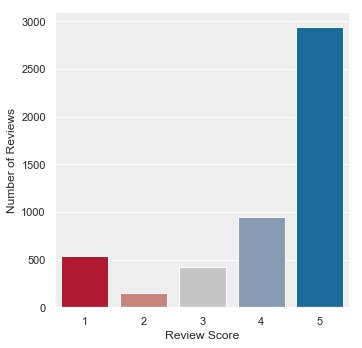

In [175]:
sns.catplot(
    x='review_score', 
    kind='count', 
    data=reviews, 
    palette=REVIEWS_PALETTE
).set(
    xlabel='Review Score', 
    ylabel='Number of Reviews',
);

In [176]:
reviews['review_creation_delay'] = (reviews['review_creation_date'] - reviews['order_purchase_timestamp']).dt.days


# TimeSeries using order purchase timestamp

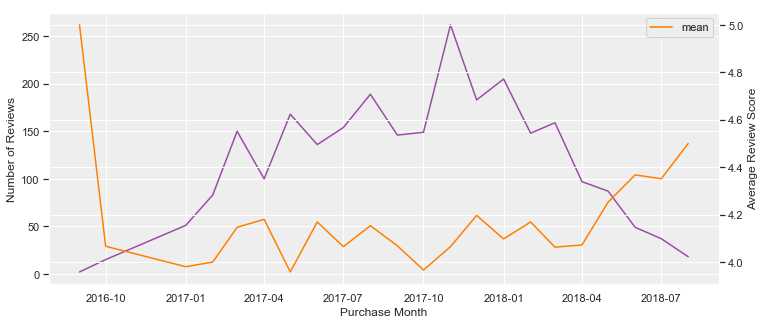

In [177]:
reviews['year_month'] = reviews['order_purchase_timestamp'].dt.to_period('M')
reviews_timeseries = reviews[reviews['review_creation_delay'] > 0].groupby('year_month')['review_score'].agg(['count', 'mean'])

ax = sns.lineplot(
    x=reviews_timeseries.index.to_timestamp(), 
    y='count', 
    data=reviews_timeseries, 
    color='#984ea3', 
    label='count'
)
ax.set(xlabel='Purchase Month', ylabel='Number of Reviews')

sns.lineplot(
    x=reviews_timeseries.index.to_timestamp(),
    y='mean',
    data=reviews_timeseries, 
    ax=ax.twinx(), 
    color='#ff7f00', 
    label='mean'
).set(ylabel='Average Review Score');
resize_plot()

In [178]:
reviews.groupby('order_status')['order_status'].count()

order_status
canceled         25
delivered      4858
invoiced         12
processing       20
shipped          61
unavailable      24
Name: order_status, dtype: int64

# Review score distribution for order status

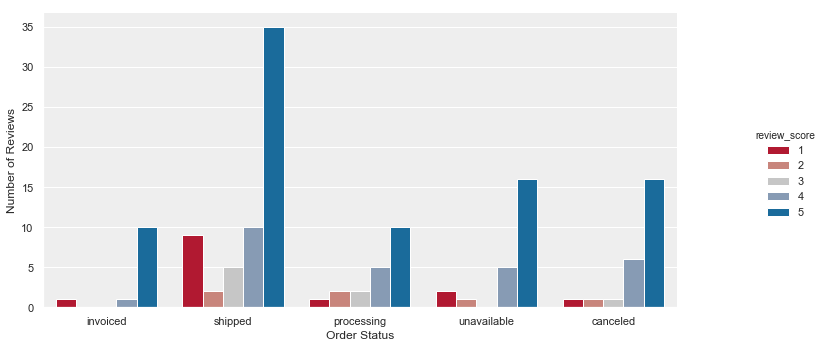

In [179]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=reviews[reviews['order_status'] != 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Order Status', ylabel='Number of Reviews');
resize_plot()

# Difference between the review_answer_timestamp and review_creation_date to analyse customers response to Olist's satisfaction survey.

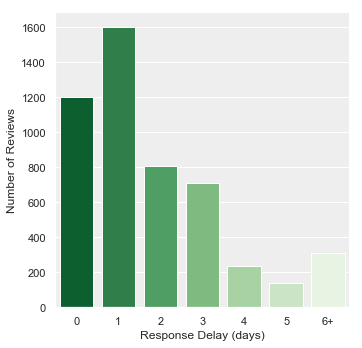

In [180]:
reviews['delay'] = (reviews['review_answer_timestamp'] - reviews['review_creation_date']).dt.days

bins = [-1, 0, 1, 2, 3, 4, 5, 99999]
labels = ['0', '1', '2', '3', '4', '5', '6+']
reviews['delay_group'] = pd.cut(reviews['delay'], bins, labels=labels)

sns.catplot(
    x='delay_group', 
    kind='count', 
    data=reviews, 
    palette=sns.color_palette('Greens_r', n_colors=7)
).set(xlabel='Response Delay (days)', ylabel='Number of Reviews');

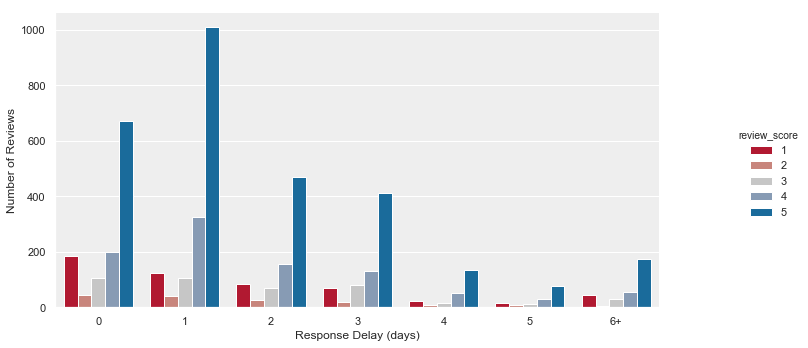

In [181]:
sns.catplot(
    x='delay_group', 
    kind='count', 
    hue='review_score', 
    data=reviews, 
    palette=REVIEWS_PALETTE
).set(xlabel='Response Delay (days)', ylabel='Number of Reviews');
resize_plot()

In [182]:
reviews['review_length'] = reviews['review_comment_message'].str.len()
#reviews[['review_score', 'review_length', 'review_comment_message']].head()

# Comment Rate

We can define comment rate as the number of non-NaN comments by the number of reviews.

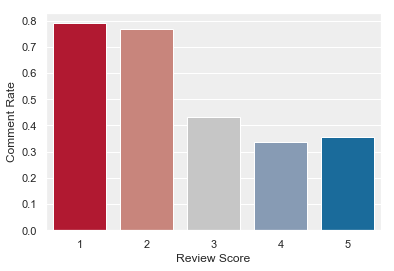

In [183]:
def comment_rate(df):
    return df['review_length'].count() / len(df)

comment_rates = reviews.groupby('review_score').apply(comment_rate)
sns.barplot(
    comment_rates.index, 
    comment_rates.values, 
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Comment Rate');

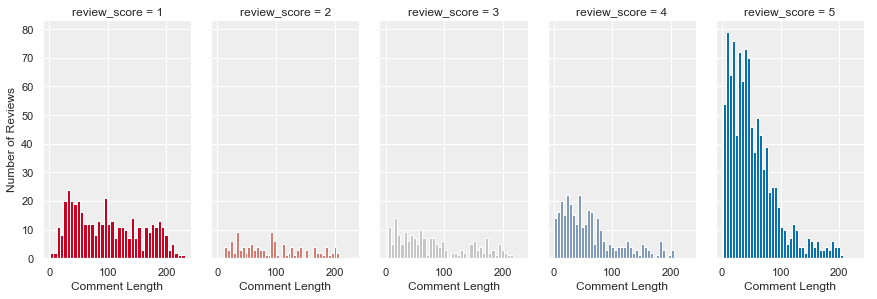

In [184]:
g = sns.FacetGrid(data=reviews, col='review_score', hue='review_score', palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12, 5)

This code is referred from kaggle:
    https://www.kaggle.com/jsaguiar/e-commerce-exploratory-analysis